In [1]:
# !pip install stable-baselines3[extra]

In [2]:
# !pip install gymnasium


In [3]:
# !pip install tqdm

In [4]:
# !pip install ipywidgets

In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from tqdm import tqdm
import random

In [6]:
# arguments
time_step = 15
epi_days = 1
# battry_cap =10000
battry_cap =10000
# battrry_charge_rate=40000
battrry_charge_rate=10000
# out_power_const =11000
out_power_const =10000

data_file ='Plant_2_Generation_Data_cleaned.csv'

df = pd.read_csv(data_file)

render_mode="human"

# Set a seed for all random operations
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [7]:
# get the number of unique values in DATE column
unique_dates = df['DATE'].unique()
num_dates = len(unique_dates)

# # get 80 % of the num_dates
# train_dates = unique_dates[:int(num_dates*0.8)]
# # get the data for the training dates
# train_df = df[df['DATE'].isin(train_dates)]
# # get the data for the testing dates
# test_df = df[~df['DATE'].isin(train_dates)]

num_train_dates = int(num_dates*0.8)
# get a list of num_train_dates number of random numbers between 0 and num_dates
train_dates = np.random.choice(unique_dates, num_train_dates, replace=False)
# get the data for the training dates
train_df = df[df['DATE'].isin(train_dates)]
# get the data for the testing dates
test_df = df[~df['DATE'].isin(train_dates)]

In [8]:
import solar_plant_gym_env
# from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy
# from solar_plant_gym_env.envs.solar_plant import SolarPlant

# hyperparameters
learning_rate = 0.001
n_episodes = 1000
start_epsilon = 1.0
# epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
exploration_fraction =0.7

# env = gym.make('solar_plant_gym_env/SolarPlant',render_mode="human")
env = gym.make('solar_plant_gym_env/SolarPlant',epi_days=epi_days,time_step=time_step, battry_cap = battry_cap,battrry_charge_rate = battrry_charge_rate,out_power_const =out_power_const,data_frame = train_df)

env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
env = DummyVecEnv([lambda: env])

# model = PPO(MlpPolicy, env, verbose=1,tensorboard_log="Training/Logs/")
model = DQN(MlpPolicy, env, verbose=0,tensorboard_log="Training/Logs/",learning_rate=learning_rate,exploration_fraction=exploration_fraction,exploration_final_eps=final_epsilon,exploration_initial_eps=start_epsilon)

print("action space :",env.action_space,"obs space :",env.observation_space)

c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\envs\registration.py:525: UserWarning: WARN: Using the latest versioned environment `solar_plant_gym_env/SolarPlant-v0` instead of the unversioned environment `solar_plant_gym_env/SolarPlant`.
  logger.warn(


action space : Discrete(3) obs space : Box(0.0, 1.0, (3,), float32)


In [9]:
from stable_baselines3.common.base_class import BaseAlgorithm


def evaluate(
    model: BaseAlgorithm,
    num_episodes: int = 100,
    deterministic: bool = True,
) -> float:
    """
    Evaluate an RL agent for `num_episodes`.

    :param model: the RL Agent
    :param env: the gym Environment
    :param num_episodes: number of episodes to evaluate it
    :param deterministic: Whether to use deterministic or stochastic actions
    :return: Mean reward for the last `num_episodes`
    """
    # This function will only work for a single environment
    vec_env = model.get_env()
    obs = vec_env.reset()
    all_episode_rewards = []
    for _ in range(num_episodes):
        episode_rewards = []
        done = False
        # Note: SB3 VecEnv resets automatically:
        # https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api
        # obs = vec_env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            # `deterministic` is to use deterministic actions
            action, _states = model.predict(obs, deterministic=deterministic)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, _info = vec_env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print(f"Mean reward: {mean_episode_reward:.2f} - Num episodes: {num_episodes}")

    return mean_episode_reward

In [10]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_episodes=100, deterministic=True)

c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Mean reward: 11.40 - Num episodes: 100


In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, warn=False)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 10.20 +/- 19.88


# Train and eval


In [12]:

# from stable_baselines3.common.callbacks import BaseCallback

# class TensorboardCallback(BaseCallback):
#     """
#     Custom callback for plotting additional values in tensorboard.
#     """

#     def __init__(self, verbose=0):
#         super().__init__(verbose)

#     def _on_step(self) -> bool:
#         # get the reward
#         value = self.model.get_env().get_attr("info_df")
#         self.logger.record("random_value", value)
#         return True

In [13]:
# Train the agent for 10000 steps
model.learn(total_timesteps=300_000,log_interval=10,progress_bar=True)

Output()

In [14]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:20.19 +/- 19.00


# Save and Reload Model


In [15]:
import os
# PPO_path = os.path.join('Training', 'Saved Models', 'PPO_model')
DQN_path = os.path.join('Training', 'Saved Models', 'DQN_model')

In [16]:
# model.save(PPO_path)
model.save(DQN_path)

In [17]:
del model

In [18]:
# model = PPO.load(PPO_path, env=env)
model = DQN.load(DQN_path, env=env)

# Test Model


In [19]:
import matplotlib.pyplot as plt

def plot_power_vs_time(df):
    """
    Plots the current power, battery charge, and total output power against the current time.
    
    Args:
        df: A pandas DataFrame containing columns: 'current_time', 'current_power', 'battery_charge', 'total_output_power'
    """
    # Ensure that the 'current_time' is in the correct format
    df['current_time'] = pd.to_datetime(df['current_time'], unit='s')

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot each of the columns
    plt.plot(df['current_time'], df['current_power'], label='Current Power', color='b', linestyle='-', marker='o')
    plt.plot(df['current_time'], df['battery_charge'], label='Battery Charge', color='g', linestyle='-', marker='x')
    plt.plot(df['current_time'], df['total_output_power'], label='Total Output Power', color='r', linestyle='-', marker='s')

    # Label the axes
    plt.xlabel('Current Time', fontsize=12)
    plt.ylabel('Power (W)', fontsize=12)

    # Add a title
    plt.title('Power and Battery Charge vs Time', fontsize=14)

    # Display the legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [20]:
n_epi_test = 10
test_env = gym.make('solar_plant_gym_env/SolarPlant',render_mode=render_mode,epi_days=epi_days, battry_cap = battry_cap,battrry_charge_rate = battrry_charge_rate,out_power_const =out_power_const,data_frame=test_df)
test_env = gym.wrappers.RecordEpisodeStatistics(test_env, buffer_length=n_episodes)
test_env = DummyVecEnv([lambda: test_env])

test_env = env

c:\Users\gwiku\miniconda3\envs\RL_new\Lib\site-packages\gymnasium\envs\registration.py:525: UserWarning: WARN: Using the latest versioned environment `solar_plant_gym_env/SolarPlant-v0` instead of the unversioned environment `solar_plant_gym_env/SolarPlant`.
  logger.warn(


In [21]:
# model = PPO.load(PPO_path, env=test_env)
model = DQN.load(DQN_path, env=test_env)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 0, Score: [55.565044]


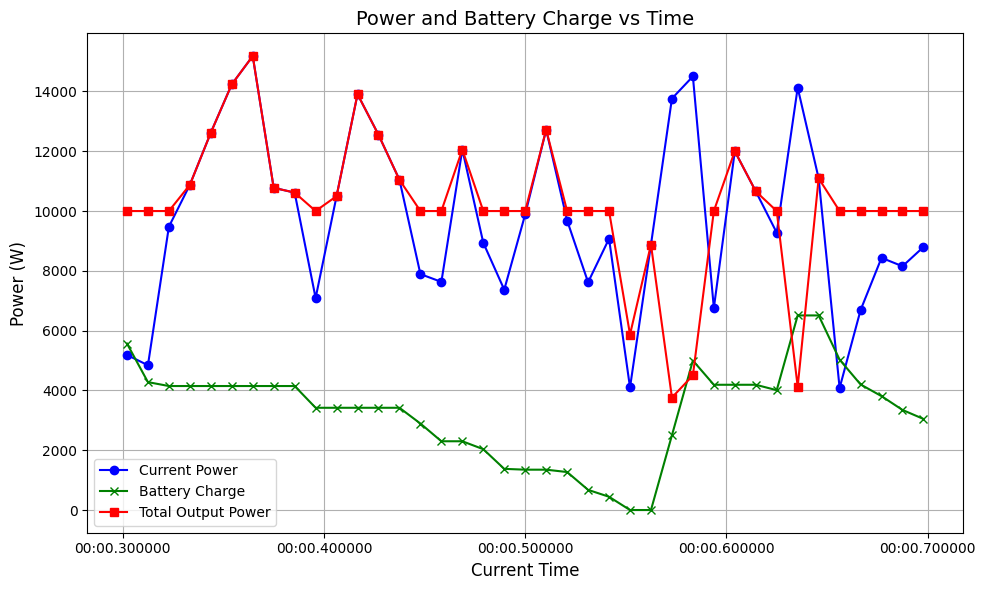

 10%|█         | 1/10 [00:00<00:02,  4.02it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 1, Score: [32.221367]


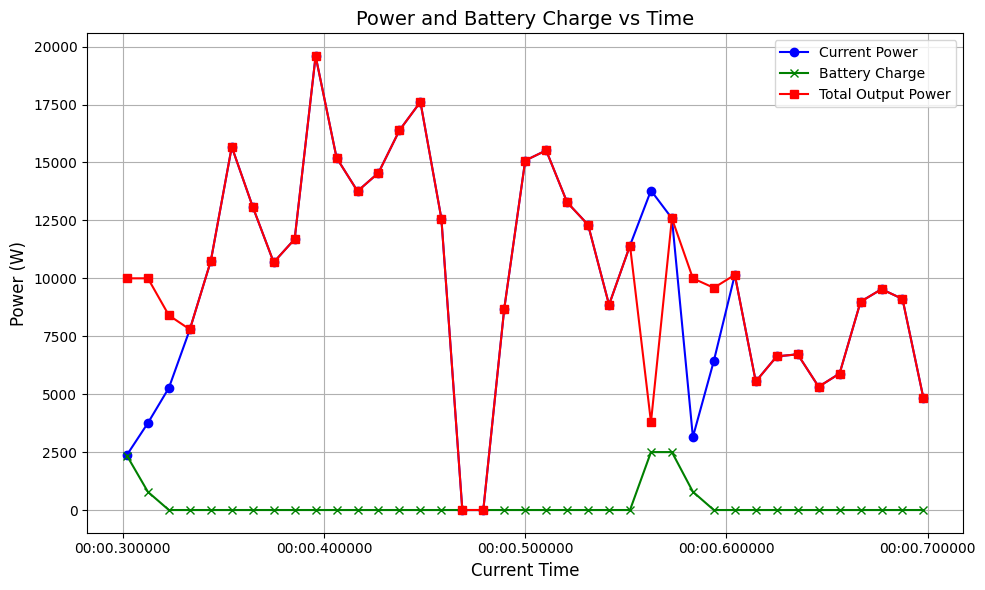

 20%|██        | 2/10 [00:00<00:01,  4.15it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 2, Score: [2.3422155]


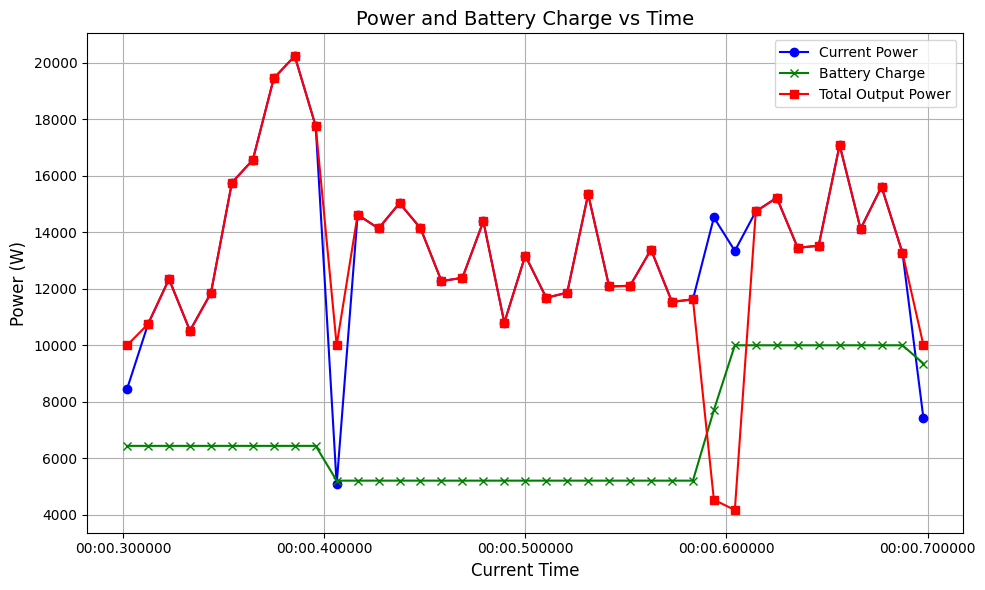

 30%|███       | 3/10 [00:00<00:01,  4.21it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 3, Score: [55.997314]


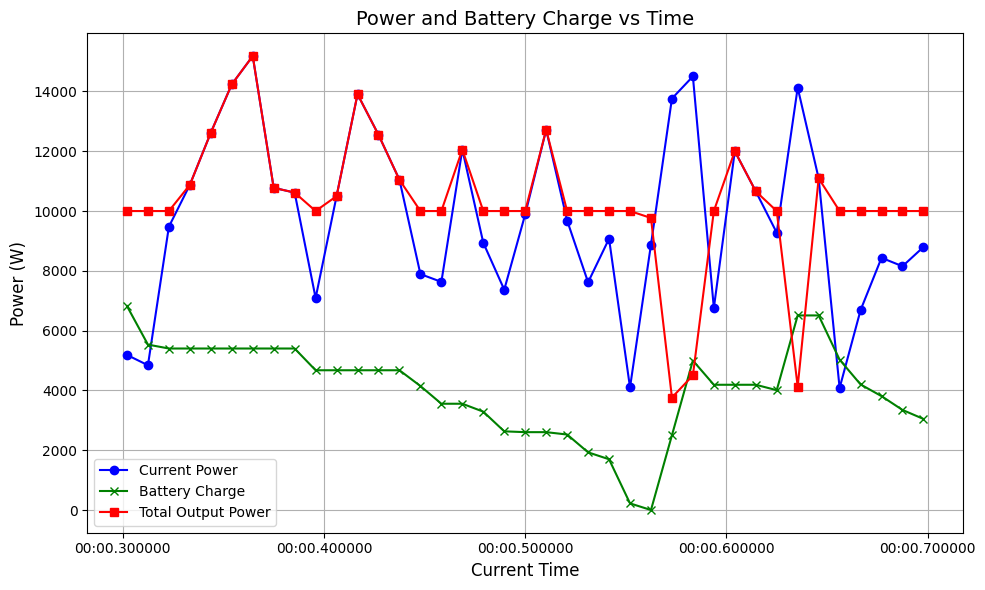

 40%|████      | 4/10 [00:00<00:01,  4.31it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 4, Score: [45.558926]


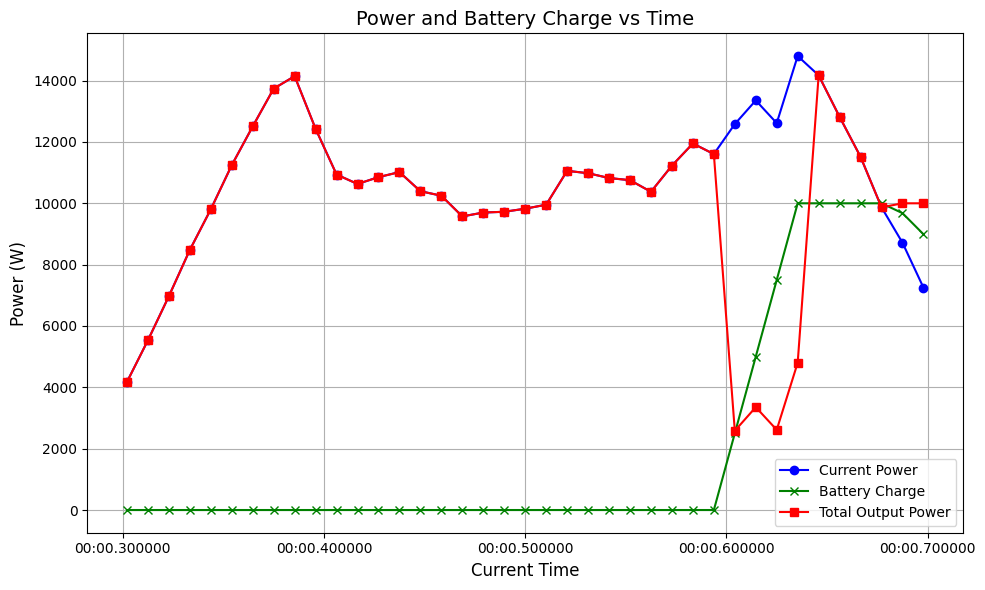

 50%|█████     | 5/10 [00:01<00:01,  4.31it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 5, Score: [43.558315]


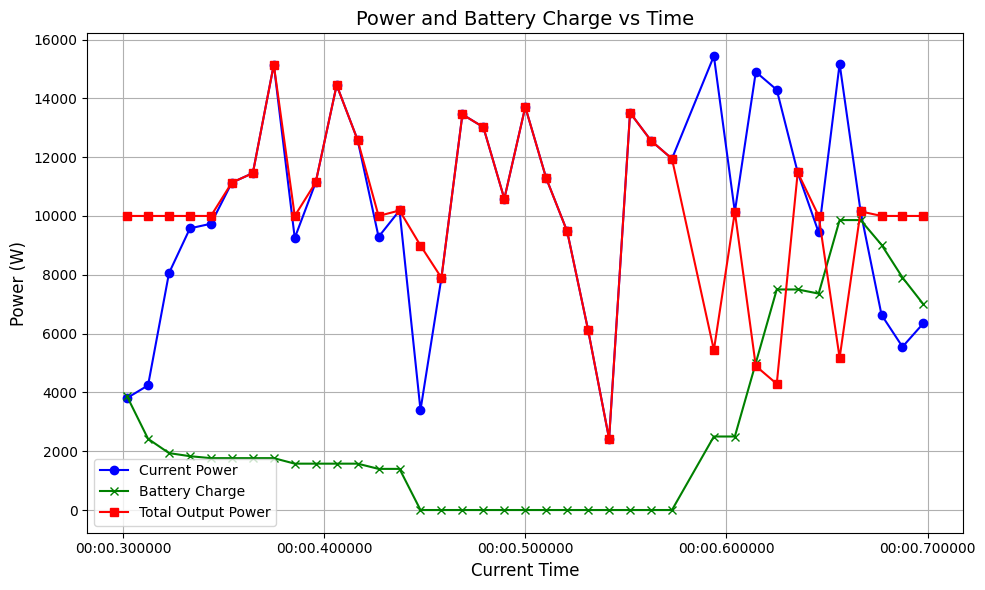

 60%|██████    | 6/10 [00:01<00:00,  4.15it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 6, Score: [-2.4124808]


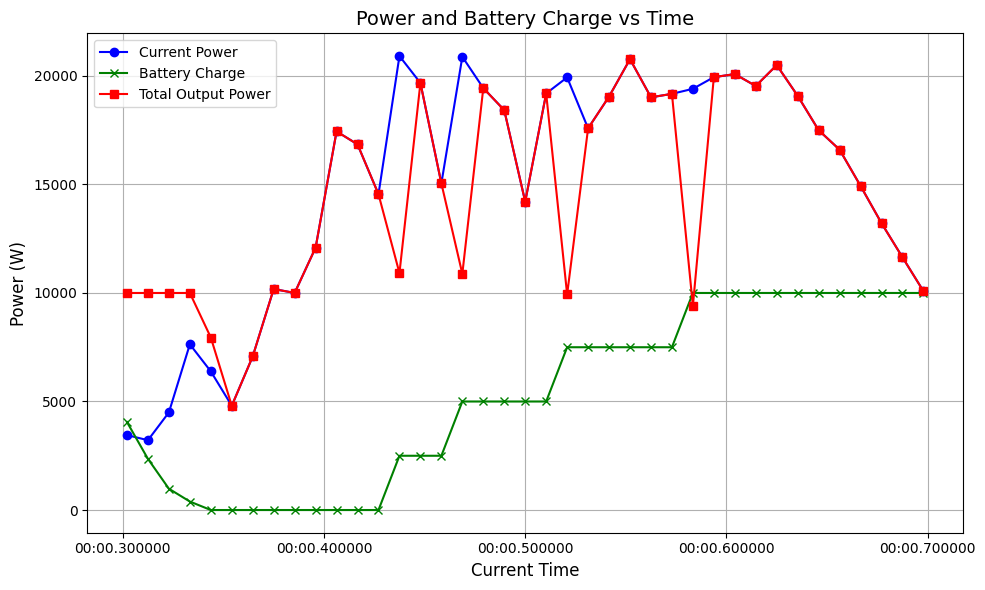

 70%|███████   | 7/10 [00:01<00:00,  4.35it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 7, Score: [-1.8125856]


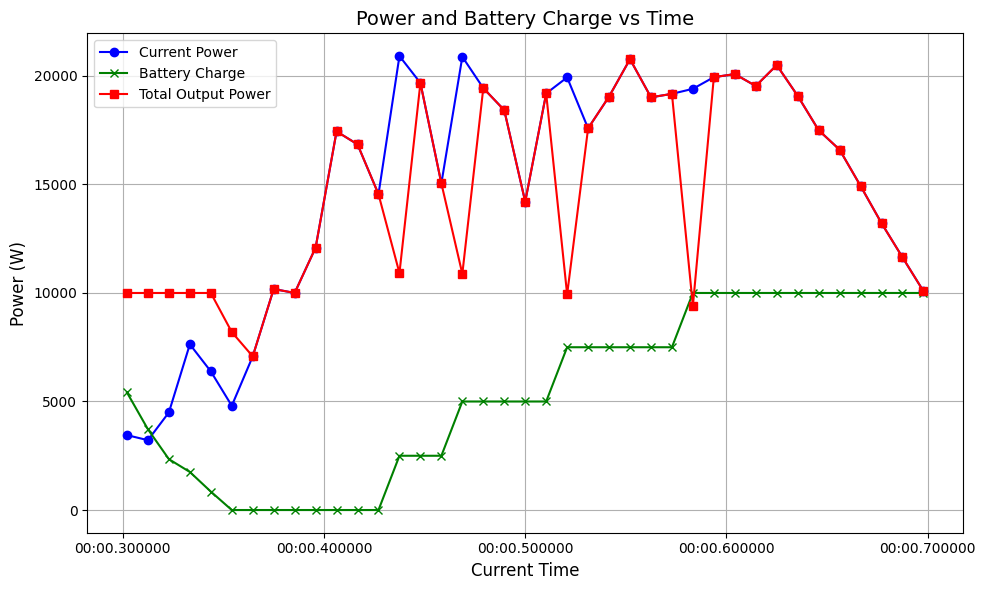

 80%|████████  | 8/10 [00:01<00:00,  4.35it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 8, Score: [28.19281]


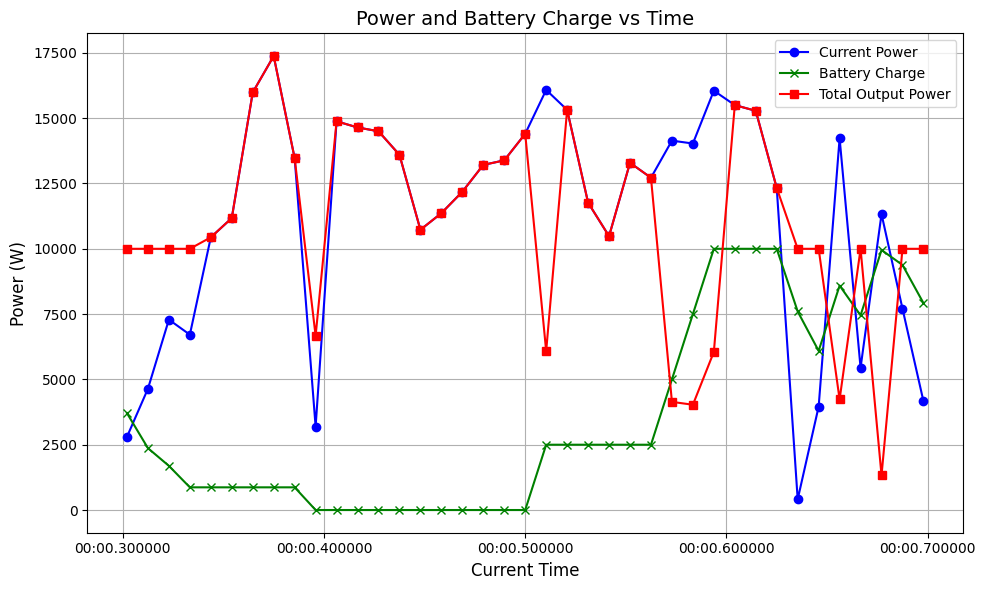

 90%|█████████ | 9/10 [00:02<00:00,  4.33it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_29716\3108454673.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)


Episode: 9, Score: [55.202156]


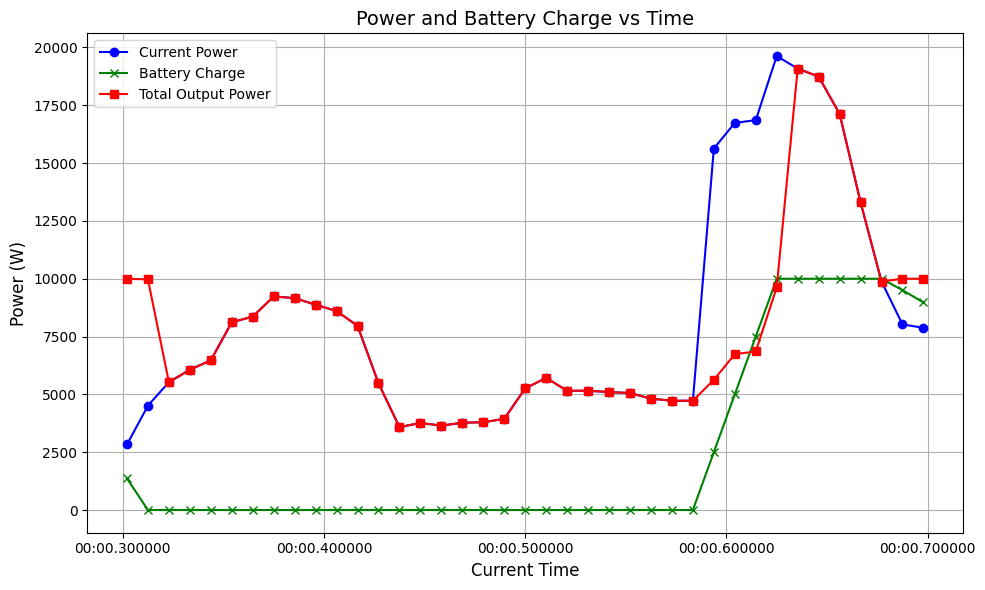

100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


In [26]:
from tqdm import tqdm
%matplotlib inline

# Test loop
for episode in tqdm(range(n_epi_test)):
    obs = test_env.reset()  # Reset the VecEnv and get only `obs`
    done = False
    score = 0
    
    epi_info_df = pd.DataFrame(columns=["current_time","current_power","battery_charge","total_output_power","action","reward"])   

    while not done:
        # Predict the action using the trained model
        action, _ = model.predict(obs)

        # Step through the VecEnv
        obs, reward, done, info = test_env.step(action)
        score += reward

        # Access additional info from the `info` dictionary (optional)
        if 'info_df' in info[0]:  # For DummyVecEnv, info is a list of dictionaries
            step_info_df=info[0]['info_df']
            
            epi_info_df = pd.concat([epi_info_df, step_info_df], ignore_index=True)
            

    print(f"Episode: {episode}, Score: {score}")
    plot_power_vs_time(epi_info_df)


In [23]:
training_log_path = os.path.join("Training","Logs", 'PPO_2')
training_log_path

'Training\\Logs\\PPO_2'

In [24]:
# tensorboard --logdir.